## Speech and Speaker Recognition - DT2119 VT19-1 

### Phoneme Recognition with Deep Neural Networks - Lab 3

In [20]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        from __future__ import print_function
import soundfile as sf                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
import numpy as np
import math
from sklearn.preprocessing import StandardScaler


from lab3_tools import *
from lab3_proto import *
from prondict import prondict

from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
%matplotlib inline

import pprint
import os
import pickle
import warnings
from IPython.display import Image
from tqdm import tqdm_notebook as tqdm

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation

from livelossplot.keras import PlotLossesCallback
from livelossplot import PlotLossesKeras

from sklearn.metrics import confusion_matrix



In [21]:
%%capture
import Feature_Extraction as FE
import hmm as hmm

### 3 Data 

In [22]:
path2info('tidigits/disc_4.1.1/tidigits/train/man/ae/z9z6531a.wav')

('man', 'ae', 'z9z6531', 'a')

In [23]:
loadAudio('../tidigits/disc_4.1.1/tidigits/train/man/ae/z9z6531a.wav')

(array([11, 13, 11, ...,  9,  9,  9], dtype=int16), 20000)

### 4.1 Target Class Defination

In [24]:
phoneHMMs = np.load('../HMM/lab2_models_all.npz')['phoneHMMs'].item()
phones = sorted(phoneHMMs.keys())
nstates = {phone:  phoneHMMs[phone]['means'].shape[0] for phone in phones}
stateList = [ph + '_' + str(id) for ph in phones for id in range(nstates[ph])]
pprint.pprint(stateList, compact=True)

# with open('stateList', 'wb') as fp:
#     pickle.dump(stateList, fp)

with open('stateList.txt', 'w') as f:
    for state in stateList:
        _ = f.write("%s\n" % state)

['ah_0', 'ah_1', 'ah_2', 'ao_0', 'ao_1', 'ao_2', 'ay_0', 'ay_1', 'ay_2', 'eh_0',
 'eh_1', 'eh_2', 'ey_0', 'ey_1', 'ey_2', 'f_0', 'f_1', 'f_2', 'ih_0', 'ih_1',
 'ih_2', 'iy_0', 'iy_1', 'iy_2', 'k_0', 'k_1', 'k_2', 'n_0', 'n_1', 'n_2',
 'ow_0', 'ow_1', 'ow_2', 'r_0', 'r_1', 'r_2', 's_0', 's_1', 's_2', 'sil_0',
 'sil_1', 'sil_2', 'sp_0', 't_0', 't_1', 't_2', 'th_0', 'th_1', 'th_2', 'uw_0',
 'uw_1', 'uw_2', 'v_0', 'v_1', 'v_2', 'w_0', 'w_1', 'w_2', 'z_0', 'z_1', 'z_2']


In [25]:
phones = sorted(phoneHMMs.keys())
print(phones)

['ah', 'ao', 'ay', 'eh', 'ey', 'f', 'ih', 'iy', 'k', 'n', 'ow', 'r', 's', 'sil', 'sp', 't', 'th', 'uw', 'v', 'w', 'z']


In [26]:
lineList = list()
with open('stateList.txt') as f:
    for line in f:
        lineList.append(line.strip('\n'))
print(lineList)
print(len(lineList))

['ah_0', 'ah_1', 'ah_2', 'ao_0', 'ao_1', 'ao_2', 'ay_0', 'ay_1', 'ay_2', 'eh_0', 'eh_1', 'eh_2', 'ey_0', 'ey_1', 'ey_2', 'f_0', 'f_1', 'f_2', 'ih_0', 'ih_1', 'ih_2', 'iy_0', 'iy_1', 'iy_2', 'k_0', 'k_1', 'k_2', 'n_0', 'n_1', 'n_2', 'ow_0', 'ow_1', 'ow_2', 'r_0', 'r_1', 'r_2', 's_0', 's_1', 's_2', 'sil_0', 'sil_1', 'sil_2', 'sp_0', 't_0', 't_1', 't_2', 'th_0', 'th_1', 'th_2', 'uw_0', 'uw_1', 'uw_2', 'v_0', 'v_1', 'v_2', 'w_0', 'w_1', 'w_2', 'z_0', 'z_1', 'z_2']
61


In [27]:
stateList.index('ay_2')

8

### 4.2 Forced Alignment

In [28]:
#file path actually
filename = '../tidigits/disc_4.1.1/tidigits/train/man/nw/z43a.wav'
samples, samplingrate = loadAudio(filename)
lmfcc = FE.mfccFn(samples)
print(lmfcc.shape)

(178, 13)


In [29]:
wordTrans = list(path2info(filename)[2])
print(wordTrans)

['z', '4', '3']


In [30]:
def words2phones(wordList, pronDict, addSilence=True, addShortPause=True):
    """ word2phones: converts word level to phone level transcription adding silence

    Args:
       wordList: list of word symbols
       pronDict: pronunciation dictionary. The keys correspond to words in wordList
       addSilence: if True, add initial and final silence
       addShortPause: if True, add short pause model "sp" at end of each word
    Output:
       list of phone symbols
    """
    phoneTrans = []
    
    if(addSilence):
        phoneTrans.append('sil')
    
    for word in wordList:
        phones = pronDict[word]
        for phone in phones:
            phoneTrans.append(phone)
        if(addSilence):
            phoneTrans.append('sp')
      
    if(addSilence):
        phoneTrans.append('sil')
    
    return phoneTrans

In [31]:
phoneTrans = words2phones(wordTrans, prondict)
print(phoneTrans)

['sil', 'z', 'iy', 'r', 'ow', 'sp', 'f', 'ao', 'r', 'sp', 'th', 'r', 'iy', 'sp', 'sil']


In [32]:
utteranceHMM = hmm.concatHMMs(phoneHMMs, phoneTrans)

In [33]:
stateTrans = [phone + "_" + str(stateid) for phone in phoneTrans
             for stateid in range(nstates[phone])]
pprint.pprint(stateTrans, compact=True)
print("\n", stateTrans[10])

['sil_0', 'sil_1', 'sil_2', 'z_0', 'z_1', 'z_2', 'iy_0', 'iy_1', 'iy_2', 'r_0',
 'r_1', 'r_2', 'ow_0', 'ow_1', 'ow_2', 'sp_0', 'f_0', 'f_1', 'f_2', 'ao_0',
 'ao_1', 'ao_2', 'r_0', 'r_1', 'r_2', 'sp_0', 'th_0', 'th_1', 'th_2', 'r_0',
 'r_1', 'r_2', 'iy_0', 'iy_1', 'iy_2', 'sp_0', 'sil_0', 'sil_1', 'sil_2']

 r_1


In [34]:
def forcedAlignment(lmfcc, phoneHMMs, phoneTrans):
    """ forcedAlignmen: aligns a phonetic transcription at the state level

    Args:
       lmfcc: NxD array of MFCC feature vectors (N vectors of dimension D)
              computed the same way as for the training of phoneHMMs
       phoneHMMs: set of phonetic Gaussian HMM models
       phoneTrans: list of phonetic symbols to be aligned including initial and
                   final silence

    Returns:
       list of strings in the form phoneme_index specifying, for each time step
       the state from phoneHMMs corresponding to the viterbi path.
    """
    utteranceHMM = hmm.concatHMMs(phoneHMMs, phoneTrans)
    obsloglik = hmm.log_multivariate_normal_density_diag(lmfcc, utteranceHMM['means'], utteranceHMM['covars'])  
    log_startprob = np.log(utteranceHMM['startprob'][:-1])
    log_transmat = np.log(utteranceHMM['transmat'][:-1,:-1])
    alpha = hmm.forward(obsloglik, log_startprob, log_transmat) 
    vloglik, vpath = hmm.viterbi(obsloglik, log_startprob, log_transmat)
    
    phones = sorted(phoneHMMs.keys())
    nstates = {phone:  phoneHMMs[phone]['means'].shape[0] for phone in phones}
    stateTrans = [ph + '_' + str(id) for ph in phoneTrans for id in range(nstates[ph])]
    
#     stateList = list()
#     with open('stateList.txt') as f:
#         for line in f:
#             stateList.append(line.strip('\n'))
    
    stateTransIdx = [stateList.index(state) for state in stateTrans]
    viterbiStateTrans = [stateTrans[i] for i in vpath]
    transcription = frames2trans(viterbiStateTrans, outfilename = "z43a.lab")

    return viterbiStateTrans

In [35]:
alignedPhonemes = forcedAlignment(lmfcc, phoneHMMs, phoneTrans)
pprint.pprint(alignedPhonemes, compact=True)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


['sil_0', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1',
 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1',
 'sil_1', 'sil_1', 'sil_1', 'sil_2', 'z_0', 'z_0', 'z_0', 'z_0', 'z_1', 'z_2',
 'z_2', 'z_2', 'z_2', 'z_2', 'z_2', 'z_2', 'z_2', 'z_2', 'z_2', 'z_2', 'iy_0',
 'iy_0', 'iy_0', 'iy_0', 'iy_0', 'iy_0', 'iy_0', 'iy_0', 'iy_1', 'iy_2', 'r_0',
 'r_0', 'r_0', 'r_0', 'r_0', 'r_0', 'r_0', 'r_0', 'r_0', 'r_0', 'r_1', 'r_2',
 'ow_0', 'ow_1', 'ow_2', 'ow_2', 'ow_2', 'ow_2', 'ow_2', 'ow_2', 'ow_2', 'ow_2',
 'ow_2', 'f_0', 'f_1', 'f_1', 'f_1', 'f_1', 'f_1', 'f_1', 'f_1', 'f_1', 'f_1',
 'f_1', 'f_1', 'f_2', 'ao_0', 'ao_1', 'ao_1', 'ao_1', 'ao_1', 'ao_1', 'ao_1',
 'ao_1', 'ao_1', 'ao_1', 'ao_1', 'ao_1', 'ao_1', 'ao_1', 'ao_1', 'ao_2', 'ao_2',
 'ao_2', 'ao_2', 'ao_2', 'ao_2', 'ao_2', 'ao_2', 'ao_2', 'ao_2', 'ao_2', 'r_0',
 'r_0', 'r_0', 'r_1', 'r_2', 'th_0', 'th_0', 'th_0', 'th_0', 'th_0', 'th_0',
 'th_0', 'th_0', 'th_0', 'th_0', 'th_1', 'th_1', 'th_1', 'th_2

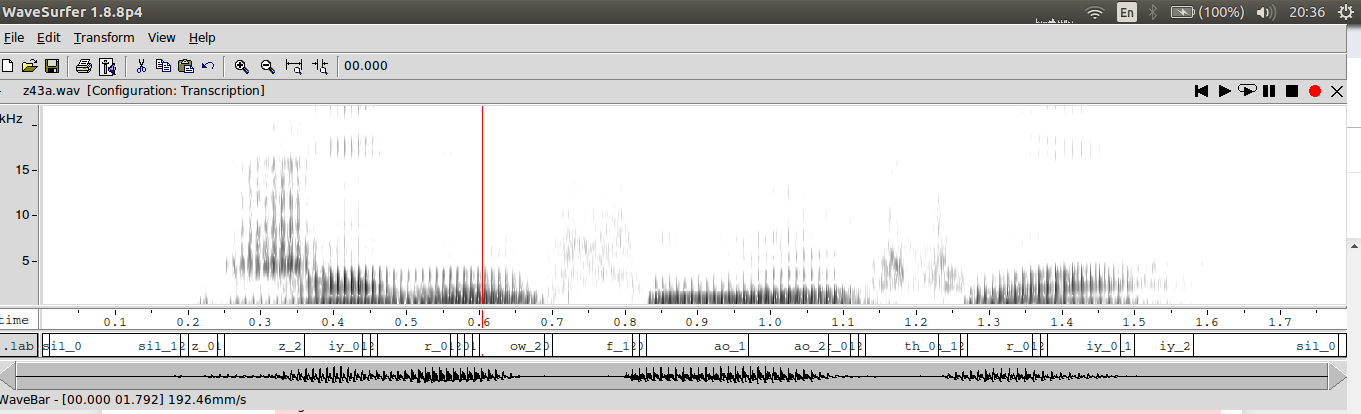

In [36]:
Image('wavesurfer.png')

### 4.3 Feature Extraction

In [37]:
def prepare_features(datapath, stateListPath, saveName):
    traindata = []
    stateList = list()
    with open(stateListPath) as f:
        for line in f:
            stateList.append(line.strip('\n'))

    totalfiles = 0
    for root, dirs, files in os.walk(datapath):
        for file in files:
            if file.endswith('.wav'):
                totalfiles += 1

    pbar = tqdm(total=totalfiles)
    for root, dirs, files in os.walk(datapath):
        for file in files:
            if file.endswith('.wav'):
                filename = os.path.join(root, file)
                samples, samplingrate = loadAudio(filename)
                lmfcc = FE.mfccFn(samples)
                mspec = FE.mspecFn(samples)            
                wordTrans = list(path2info(filename)[2])
                phoneTrans = words2phones(wordTrans, prondict, addShortPause=False)
                targets = forcedAlignment(lmfcc, phoneHMMs, phoneTrans)
                targetsIdx =  np.array([stateList.index(target) for target in targets])

                traindata.append({'filename': filename,
                                 'lmfcc': lmfcc,
                                 'mspec': mspec,
                                 'targets':targetsIdx})
                pbar.update(1)
                pbar.refresh()
    pbar.close()
    #Never terminates for some reason and gets struck when there is a file of same name
    print("saving npz...please wait!")
    np.savez(saveName, traindata=traindata)
    return traindata

In [38]:
print("Do you really want to do this?")
a = input()
if(a == 'yes'):
    traindata = prepare_features('../tidigits/disc_4.1.1/tidigits/train', 'stateList.txt', 'traindata.npz')

Do you really want to do this?
nope


### 4.4 Training and Validation Sets

In [39]:
traindata = np.load('traindata.npz')
traindata = dict(zip(("{}".format(k) for k in traindata), (traindata[k] for k in traindata)))

male_speakers = np.unique([traindata['traindata'][i]["filename"].split('/')[6] 
                      for i in range(len(traindata['traindata'])) 
                      if traindata['traindata'][i]["filename"].split('/')[5] == 'man'])
female_speakers = np.unique([traindata['traindata'][i]["filename"].split('/')[6] 
                      for i in range(len(traindata['traindata'])) 
                      if traindata['traindata'][i]["filename"].split('/')[5] == 'woman'])


m_train_speakers = male_speakers[0:math.floor(len(male_speakers)*0.9)]
m_valid_speakers = male_speakers[math.floor(len(male_speakers)*0.9):]

m_train_data =  [traindata['traindata'][i] for i in range(len(traindata['traindata'])) 
                  if traindata['traindata'][i]["filename"].split('/')[6] in m_train_speakers]

m_valid_data =  [traindata['traindata'][i] for i in range(len(traindata['traindata'])) 
                  if traindata['traindata'][i]["filename"].split('/')[6] in m_valid_speakers]

w_train_speakers = female_speakers[0:math.floor(len(female_speakers)*0.9)]
w_valid_speakers = female_speakers[math.floor(len(female_speakers)*0.9):]

w_train_data =  [traindata['traindata'][i] for i in range(len(traindata['traindata'])) 
                  if traindata['traindata'][i]["filename"].split('/')[6] in w_train_speakers]

w_valid_data =  [traindata['traindata'][i] for i in range(len(traindata['traindata'])) 
                  if traindata['traindata'][i]["filename"].split('/')[6] in w_valid_speakers]

training_data = m_train_data + w_train_data
validation_data = m_valid_data + w_valid_data

print("Training Data : ", len(training_data)/len(traindata['traindata'])*100)
print("Validation Data :", len(validation_data)/len(traindata['traindata'])*100)

Training Data :  89.2844717615679
Validation Data : 10.7155282384321


### 4.5 Acoustic Context (Dynamic Features)

In [40]:
def dynamize_features(data, feature_type):
    for sample in tqdm(data):
        dynamic_features = []
        max_idx = len(sample[feature_type]) - 1
        for idx, feature in enumerate(sample[feature_type]):
            dynamic_feature = np.zeros((7, feature.shape[0]))

            dynamic_feature[0] = sample[feature_type][np.abs(idx - 3)]
            dynamic_feature[1] = sample[feature_type][np.abs(idx - 2)]
            dynamic_feature[2] = sample[feature_type][np.abs(idx - 1)]
            dynamic_feature[3] = sample[feature_type][idx]
            dynamic_feature[4] = sample[feature_type][max_idx - np.abs(max_idx - (idx + 1))]
            dynamic_feature[5] = sample[feature_type][max_idx - np.abs(max_idx - (idx + 2))]
            dynamic_feature[6] = sample[feature_type][max_idx - np.abs(max_idx - (idx + 3))]
            dynamic_features.append(dynamic_feature)
        sample['dynamic_'+feature_type] = np.array(dynamic_features)
    return data

In [42]:
training_data = dynamize_features(training_data[0:10], 'lmfcc')
training_data = dynamize_features(training_data[0:10], 'mspec')
validation_data = dynamize_features(validation_data[0:10], 'lmfcc')
validation_data = dynamize_features(validation_data[0:10], 'mspec')
print("Original Features ", training_data[0]["lmfcc"].shape)
print("Dynamic Features ", training_data[0]['dynamic_lmfcc'].shape)


Original Features  (258, 13)
Dynamic Features  (258, 7, 13)


In [22]:
print("Really!!?")
a = input()
if (a == 'yes'):
    testdata = np.load('testdata.npz')
    testdata = dict(zip(("{}".format(k) for k in tqdm(testdata)), (testdata[k] for k in testdata)))
    testdata = [testdata["traindata"][x] for x in tqdm(range(len(testdata["traindata"])))]
    print("1")
    testing_data = dynamize_features(testdata, 'lmfcc')
    testing_data = dynamize_features(testdata, 'mspec')
    print("2")
    np.savez("dynamic_test_data", testing_data=testing_data)

Really!!?
no


Time steps, Features (258, 13)


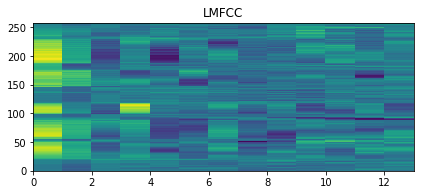

In [43]:
lmfcc = training_data[0]['lmfcc']
_ = plt.rcParams['figure.figsize'] = [15, 6]
_ = plt.subplot(221).set_title("LMFCC")
_ = plt.pcolormesh(lmfcc)
print("Time steps, Features", lmfcc.shape)

#### checking out the shapes after dynamic features generation

In [46]:
print(len(training_data))
print(len(validation_data))

lmfcc = training_data[0]['dynamic_lmfcc']
print(lmfcc.shape)

mspec = training_data[0]['dynamic_mspec']
print(mspec.shape)
# mspec_val = validation_data[0]['dynamic_mspec']
# print(mspec_val.shape)

10
10
(258, 7, 13)
(258, 7, 40)


### 4.6 Feature Standardisation

#### Additionally, Extract features and flatten the data for Neural Network

In [47]:
def get_train_val(training_data, validation_data, feature_type):
    
    train_x = [training_data[x][feature_type] for x in tqdm(range(len(training_data)))]
    val_x = [validation_data[x][feature_type] for x in tqdm(range(len(validation_data)))]
    
    train_y = np.asarray([training_data[x]['targets'] for x in tqdm(range(len(training_data)))])
    val_y = np.asarray([validation_data[x]['targets'] for x in tqdm(range(len(validation_data)))])
    print("Performing Train Flattening ...")
    
    train_x = np.concatenate(train_x, axis = 0)
    if len(train_x.shape) > 2:
        train_x = np.reshape(train_x,(train_x.shape[0], train_x.shape[1]*train_x.shape[2]))
    print("Performing Val Flattening ...")
    val_x = np.concatenate(val_x, axis = 0)
    if len(val_x.shape) > 2:
        val_x = np.reshape(val_x,(val_x.shape[0], val_x.shape[1]*val_x.shape[2]))
    print("Performing Ground Truth Flattening ...")
    train_y = np.concatenate(train_y, axis = 0)
    train_y = np.reshape(train_y,(train_y.shape[0],1))

    val_y = np.concatenate(val_y, axis = 0)
    val_y = np.reshape(val_y,(val_y.shape[0],1))
    
    
    #this case we are using only lmfcc replace lmfcc with mspec if needed
    #TODO should do this for test as aswell ..using the same scaler
    print("Performing Standardization ...")

    scaler = StandardScaler()
    scaler = scaler.fit(train_x)

    train_x = scaler.transform(train_x)
    val_x = scaler.transform(val_x)

    train_x = train_x.astype('float32')
    val_x = val_x.astype('float32')

    stateList = list()
    with open('stateList.txt') as f:
        for line in f:
            stateList.append(line.strip('\n'))
    output_dim = len(stateList)

    print("Performing Categorisation  ...")
    #Categorial format of ground truth
    train_y = np_utils.to_categorical(train_y, output_dim)
    val_y = np_utils.to_categorical(val_y, output_dim)
    print("Done !!!")
    #scaler to repeat for test
    return train_x, train_y, val_x, val_y, scaler

In [48]:
train_x, train_y, validation_x, validation_y, scaler = get_train_val(training_data[0:12], validation_data[0:12], 'dynamic_mspec')


Performing Train Flattening ...
Performing Val Flattening ...
Performing Ground Truth Flattening ...
Performing Standardization ...
Performing Categorisation  ...
Done !!!


In [49]:
print(train_x.shape)
print(train_y.shape)

print(validation_x.shape)
print(validation_y.shape)

print(train_x[0].shape)
print(train_y[0].shape)

(2066, 280)
(2066, 61)
(1756, 280)
(1756, 61)
(280,)
(61,)


### Final data samples for training

In [ ]:
# np.savez("sample_train_x", train=lmfcc_train_x[0:12,:])
# np.savez("sample_train_y", train=lmfcc_val_x[0:12,:])
# np.savez("sample_val_x", val=train_y[0:12,:])
# np.savez("sample_val_y", val=val_y[0:12,:])

### 5 Phoneme Recognition with Deep Neural Networks

### Model 1

In [ ]:
train_x, train_y, validation_x, validation_y, scaler = get_train_val(training_data, validation_data, 'dynamic_mspec')


Performing Train Flattening ...


In [ ]:
%%time
#Parameters
input_dim = train_x.shape[1]
Dense_Activation = 'relu'
L = 4

modelName = "mspec_L4" 


stateList = list()
with open('stateList.txt') as f:
    for line in f:
        stateList.append(line.strip('\n'))

output_dim = len(stateList)

#Model
model = Sequential()
model.add(Dense(256, input_dim=input_dim, activation=Dense_Activation))
for i in range(L - 1):
    model.add(Dense(256, activation=Dense_Activation))
model.add(Dense(output_dim, activation='softmax'))

#Compile Model
model.compile(optimizer='x',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train model
history = model.fit(train_x, train_y, 
                    epochs=10,
                    batch_size=256, 
                    validation_data = (validation_x, validation_y),
                    callbacks=[PlotLossesKeras(fig_path="model_data/"+modelName+".png")],
                    verbose=0)

with open("model_data/"+modelName, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
    
model.save("model_data/"+modelName+'.h5')               

In [ ]:
%%time
#Parameters
input_dim = train_x.shape[1]
Dense_Activation = 'relu'
L = 4

modelName = "dy_mspec_L4" 


stateList = list()
with open('stateList.txt') as f:
    for line in f:
        stateList.append(line.strip('\n'))

output_dim = len(stateList)

#Model
model = Sequential()
model.add(Dense(256, input_dim=input_dim, activation=Dense_Activation))
for i in range(L - 1):
    model.add(Dense(256, activation=Dense_Activation))
model.add(Dense(output_dim, activation='softmax'))

#Compile Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train model
history = model.fit(train_x, train_y, 
                    epochs=10,
                    batch_size=256, 
                    validation_data = (validation_x, validation_y),
                    callbacks=[PlotLossesKeras(fig_path="model_data/"+modelName+".png")],
                    verbose=0)

with open("model_data/"+modelName, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
    
model.save("model_data/"+modelName+'.h5')               

### Evaluate Model

In [50]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.viridis):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def levenshteinDistance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]


In [51]:
stateList = list()
with open('stateList.txt') as f:
    for line in f:
        stateList.append(line.strip('\n'))

output_dim = len(stateList)

In [53]:
testdata = np.load('testdata.npz')
testdata = dict(zip(("{}".format(k) for k in testdata), (testdata[k] for k in testdata)))

testing_data =  [testdata['traindata'][i] for i in range(1000)]
#testing_data =  [testdata['traindata'][i] for i in range(len(testdata['traindata']))]

test_x = np.asarray([testing_data[x]["lmfcc"] for x in tqdm(range(len(testing_data)))])
test_y = np.asarray([testing_data[x]["targets"] for x in tqdm(range(len(testing_data)))])

print(test_x.shape)
print(test_y.shape)

test_x = np.concatenate(test_x, axis = 0)
if len(test_x.shape) > 2:
    test_x = np.reshape(test_x,(test_x.shape[0], test_x.shape[1]*test_x.shape[2]))

test_y = np.concatenate(test_y, axis = 0)
test_y = np.reshape(test_y,(test_y.shape[0],1))

test_y = np_utils.to_categorical(test_y, output_dim)

print(test_x.shape)
print(test_y.shape)



(1000,)
(1000,)
(172631, 13)
(172631, 61)


Model accuracy - frame by frame - state level: 0.05413859619651164
Normalized confusion matrix
[[0.1266256  0.02053388 0.         ... 0.         0.         0.        ]
 [0.         0.00255319 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.00127714 0.00766284 0.         ... 0.01149425 0.         0.00255428]
 [0.         0.00634417 0.         ... 0.09238699 0.00039651 0.00674068]
 [0.         0.         0.         ... 0.02036199 0.         0.        ]]


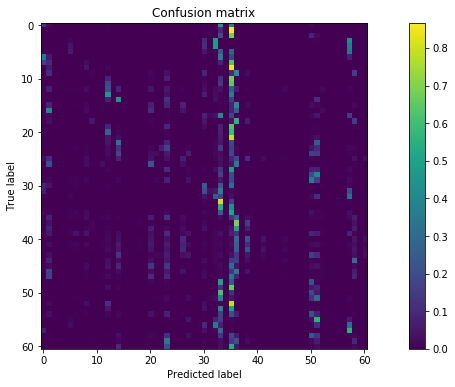

In [54]:
from keras.models import load_model

model = load_model("model_data/lmfcc_L4.h5")

predictions = model.predict(test_x)
ground_truths = np.argmax(test_y, axis = 1)
predicted_classes = np.argmax(predictions, axis = 1)

accuracy = np.count_nonzero(ground_truths == predicted_classes) / float(len(ground_truths))
print("Model accuracy - frame by frame - state level: " + str(accuracy))
labels = [i for i in range(len(stateList))] 

cnf_matrix = confusion_matrix(ground_truths, predicted_classes, labels = labels)
plot_confusion_matrix(cnf_matrix, classes = stateList, normalize=True)
plt.show()

Model accuracy - frame by frame - phoneme level: 0.15632186571357404
Normalized confusion matrix
[[3.58608771e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.16029380e-03 0.00000000e+00 0.00000000e+00 3.79347591e-01
  0.00000000e+00 1.69583063e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  4.96867574e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
  4.08079499e-01]
 [0.00000000e+00 2.54182457e-02 2.77289953e-04 0.00000000e+00
  2.39301229e-01 0.00000000e+00 0.00000000e+00 2.04270265e-02
  0.00000000e+00 7.05240780e-01 4.06691931e-03 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.31869859e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
  4.43663925e-03]
 [8.25423029e-04 2.88898060e-03 9.57490714e-02 4.12711515e-04
  2.75141010e-04 0.00000000e+00 0.00000000e+00 4.12711515e-03
  0.00000000e+00 4.62649608e-01 2.32906865e-01 3.71440363e-03
  2.88898060e-03 8.25423029e-04 5.50282020e-04 3.43926262e-03

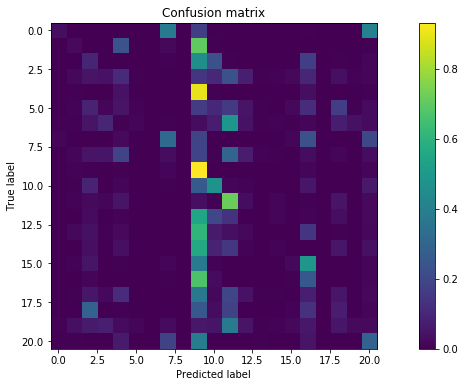

In [60]:
phoneme_dict = {phoneme: index for (index, phoneme) in enumerate(phones)}

# Convert state prediction to phonemes
phoneme_ground_truths = np.array([phoneme_dict[stateList[gt][:-2]] for gt in ground_truths])
phoneme_predicted_classes = np.array([phoneme_dict[stateList[pred][:-2]] for pred in predicted_classes])

phoneme_accuracy = np.count_nonzero(phoneme_ground_truths == phoneme_predicted_classes) / float(len(phoneme_ground_truths))
print("Model accuracy - frame by frame - phoneme level: " + str(phoneme_accuracy))


cnf_matrix = confusion_matrix(phoneme_ground_truths, phoneme_predicted_classes, labels = list(phoneme_dict.values()))
_ = plot_confusion_matrix(cnf_matrix, classes = list(phoneme_dict.keys()), normalize=True)
_ = plt.show()

###### Checkout training results in model_data folder